# API Message Structure

This tutorial introduces the format used for passing messages to the GridAPPS-D API and how to wrap those messages using the GridAPPSD-Python Library.

---

## 1. Python Dictionaries VS JSON Strings

One of the confusing aspects of passing messages to and from the GridAPPS-D Platform and APIs is the difference between Python Dictionaries and JSON scripts, which look identical.

__JSON__ is a _serialization format_. That is, JSON is a way of representing structured data in the form of a textual string.

A __Python Dictionary__ is a _data structure_. That is, it is a way of storing data in memory that provides certain abilities to the code: in the case of dictionaries, those abilities include rapid lookup and enumeration.

It is possible to convert between the two by importing the JSON library: `import json`. Full documentation of JSON-Python interoperability and usage is available in [Python Docs](https://docs.python.org/3/library/json.html).

Use the `json.dumps()` method to serialize a dictionary as a JSON string. Use the `json.loads()` to import a JSON file and convert it into a dictionary. But the two are not the same: dictionaries are for working with data in your program, and JSON is for storing it or sending it around between programs.

With the GridAPPSD-Python Library, it is possible to pass query arguments as either a python dictionary or as a string. Both approaches will provide the same results.

__1) Format API call message as a dictionary__

This is the most direct approach, and will be used most often throughout this set of notebook tutorials. The format and structure of the python dictionary is explained in the next section.

In [ ]:
model_mrid = "_49AD8E07-3BF9-A4E2-CB8F-C3722F837B62" # IEEE 13 Node used for all example queries

# Format message as python dictionary
message = {
    "requestType": "QUERY_OBJECT_IDS",
    "resultFormat": "JSON",
    "modelId": model_mrid,
    "objectType": "LoadBreakSwitch"
} 

In [ ]:
# Specify correct topic
topic = "goss.gridappsd.process.request.data.powergridmodel"

# Pass API Call to GridAPPS-D Platform
gapps.get_response(topic, message)

__2) Format API call message as a string__

This approach uses quotations (either `'  '` or `"   "`) to wrap the API call (identical to the python dictionary) as JSON-formatted text, concatenated into a string. 

In [ ]:
model_mrid = "_49AD8E07-3BF9-A4E2-CB8F-C3722F837B62" # IEEE 13 Node used for all example queries

# Format message as JSON text wrapped as a string
message = """
{
    "requestType": "QUERY_OBJECT_IDS",
    "resultFormat": "JSON",
    "modelId": "%s",
    "objectType": "LoadBreakSwitch"
} 
""" % model_mrid

In [ ]:
# Specify correct topic
topic = "goss.gridappsd.process.request.data.powergridmodel"

# Pass API Call to GridAPPS-D Platform
gapps.get_response(topic, message)

---

## 2. Structure of a GridAPPS-D Message

The structure of messages in GridAPPS-D follows that of a Python Dictionary using a data structure that is more generally known as an associative array. An excellent tutorial on advanced usage of the python dictionary structure is available on [Real Python](https://realpython.com/python-dicts/).

A dictionary consists of a collection of __key-value pairs__. Each key-value pair maps the __key__ to its associated __value__.

* A dictionary is defined by enclosing a comma-separated list of key-value pairs in curly braces ( __{ }__ ). 

* A colon ( __:__ ) separates each key from its associated value. 

* Square brackets ( __[ ]__ ) are used for a list of values associated to a particular key. 

* Additional curly braces ( __{ }__ ) can be used for cases where multiple key-value pairs (e.g. equipment setpoints) are associated with a particular key (e.g. an equipment class).


The general dictionary format used for GridAPPS-D messages is

```
message = {
    "key1": "value1",
    "key2": ["value21", "value22"],
    "key3": {
        "key31": "value31",
        "key32": "value32"
        },
      .
      .
      .
    "key": "value"
}

```

__Important__: Be sure to pay attention to placement of commas ( __,__ ) at the end of each line. Commas are placed at the end of each line _except_ the last line. Incorrect comma placement will result in a syntax exception. 

The particular set of key-value pairs for each GridAPPS-D API is covered in detail in Lessons 2.1 through 2.7.

---

## 3. Parsing Returned Data

After passing an API call, the GridAPPS-D Platform returns a JSON string that is subsequently converted into a python dictionary by the GridAPPSD-Python Library. This section will outline how to parse the data returned. 

For this example, we are going to use a simple query from the PowerGrid Model API (covered in Lesson 2.2.) to obtain the details of a piece of equipment using its unique mRID (introduced in the next lesson).

In [ ]:
model_mrid = "_49AD8E07-3BF9-A4E2-CB8F-C3722F837B62" # IEEE 13 Node used for all example queries

# Specify correct topic
topic = "goss.gridappsd.process.request.data.powergridmodel"

message = {
        "modelId": model_mrid,
        "requestType": "QUERY_OBJECT_DICT",
        "resultFormat": "JSON",
        "objectType": "LinearShuntCompensator",
}

# Pass API Call to GridAPPS-D Platform
response = gapps.get_response(topic, message)

import json
with open("foo.txt", 'w') as out:
    out.write(json.dumps(response, indent=2))

The structure of the python dictionary returned by the API is three key-value pairs for the keys of 

* `'data'` -- this is the data you requested

* `'responseComplete'` -- true or false

* `'id'` -- unique id associated with the API response dictionary


A typical API response will the structure below:

```
response = {
    'data': [{'key1': 'value1',
        'key2': ['value21', 'value22']},
        {'key1': 'value1',
         'key2': ['value21', 'value22']}],
     'responseComplete': True,
     'id': '12345678'
}
```

The first step is to filter the dictionary to just the data requested: `response['data']`. The result will be a list object.

Note: _some_ API calls will also need to additional filters of `[results][bindings]`. The STOMP Client presented in the next section is very helpful for previewing the structure of the dictionary returned by GridAPPS-D.

In [ ]:
response = gapps.get_response(topic, message)
response_obj = response['data']

As `response_obj` is of the python type `list` rather than `dict`, it is necessary to use numerical indices instead of keys to access the values. A simple `for` loop is very helpful here. 

In this example, we want to filter the results to create a list that contains just the name and mRID of the capacitor banks in the model.

In [ ]:
capacitors = []
for index in response_obj:
    cap_name = index['IdentifiedObject.name']
    cap_mrid = index['id']
    message = dict(name = cap_name,
                   mrid = cap_mrid)
    capacitors.append(message)

[[Return to Top](#Table-of-Contents)]

## 4. Using the STOMP Client

The GridAPPS-D Visualization App includes a feature to pass API call messages through the GUI using the Simple Text Oriented Messaging Protocol (STOMP).

Open the Viz App, which is hosted on [localhost:8080](http://localhost:8080/) (note: cloud-hosted installations will use the IP address of the server). 

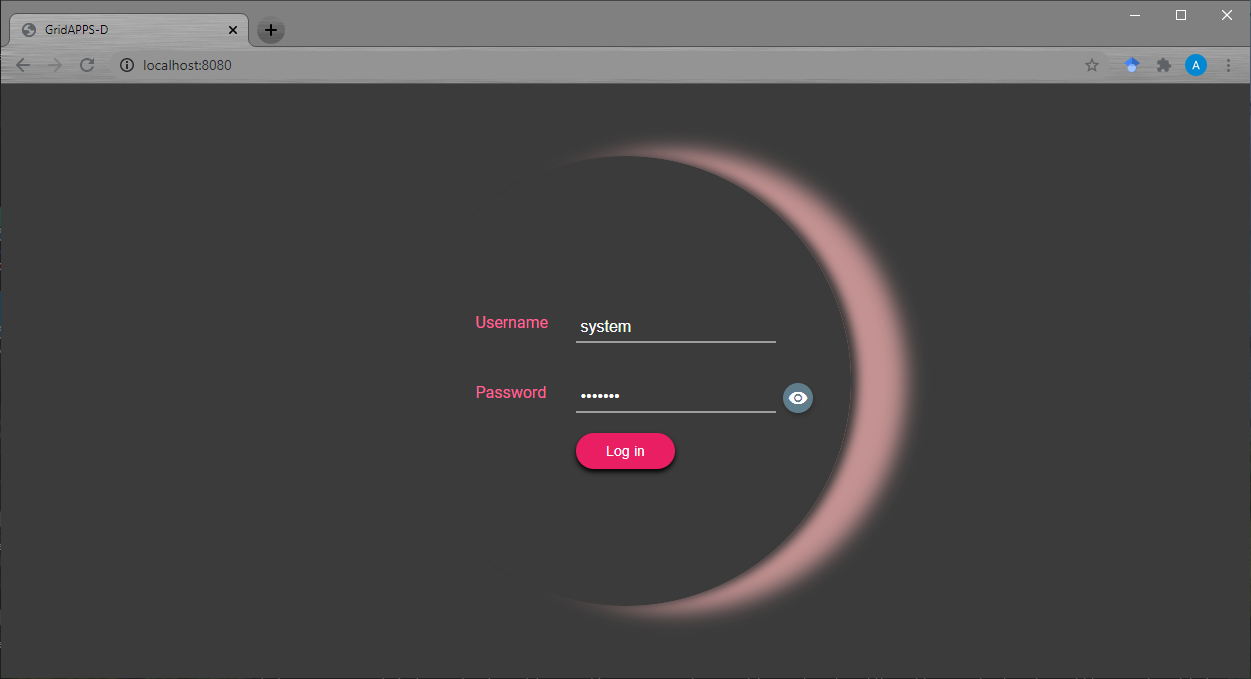

Log in and click on the menu in the top left corner of the browser window:

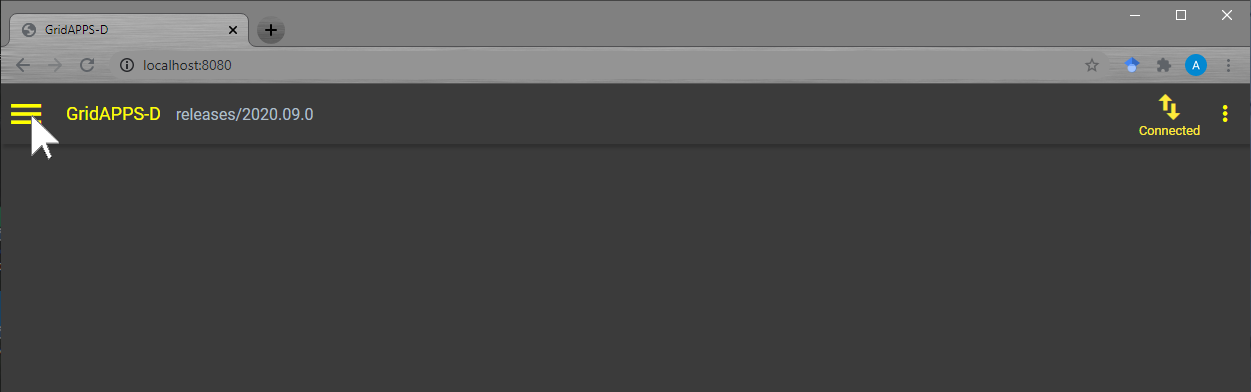


Select __Stomp Client__ from the drop-down menu:

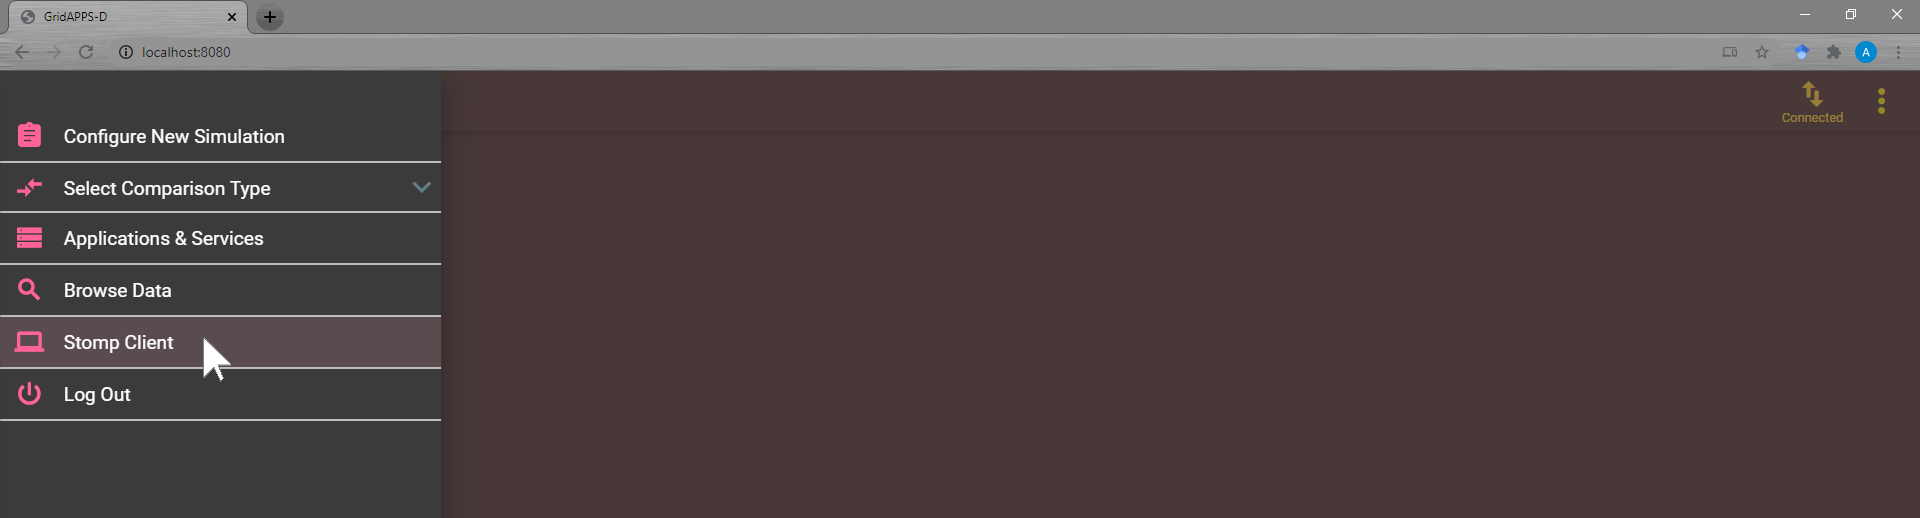

This opens the STOMP Client, which can be used to pass a message to any of the GridAPPS-D APIs to preview results or debug the API call message.

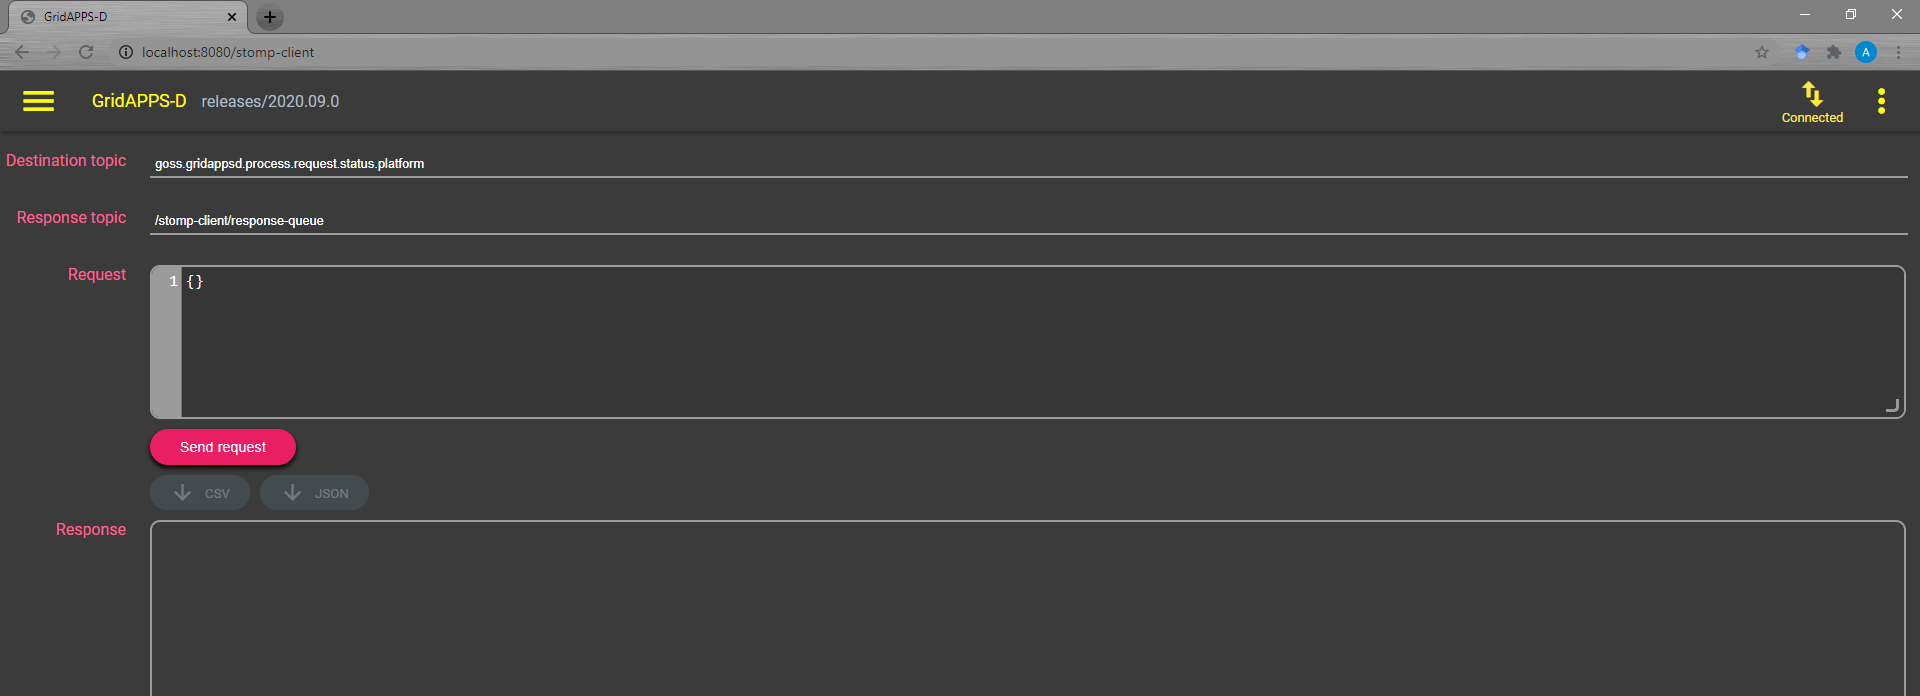

### 4.1. Specifying the Topic

The appropriate GridAPPS-D topic  needs to be copied and pasted into the __Destination Topic__ box at the top of the window. The topic specifies on which channel the STOMP Client will communicate with the GridAPPS-D Platform and to which API the message needs to be delivered. 

A complete list of GridAPPS-D topics was provided in [Lesson 1.4.](Lesson%201.4.%20GridAPPS-D%20Topics.ipynb) and will also be provided in context for each of the API calls detailed in subsequent lessons. 

__IMPORTANT:__ Remember to remove the python wrapping quotations at the beginning and end of the topic. For example, if the python-wrapped topic was

`topic = "goss.gridappsd.process.request.data.powergridmodel" # Specify the topic`

then the topic that is entered in the Stomp Client __Destination Topic__ box is simply

`goss.gridappsd.process.request.data.powergridmodel`

__IMPORTANT:__ The GridAPPSD-Python shortcut functions will not work in the STOMP Client. The full text string versions must be used. 



### 4.2. Entering the Request Message

The __Request__ box accepts an API call message identical to those provided in these notebook lessons.

__IMPORTANT:__ Remember to remove the python wrapping at the beginning and end of the message. For example, if the python-wrapped message was

`message = "{"requestType": "QUERY_MODEL_NAMES", "resultFormat": "JSON"}" # Sample PowerGrid Model API Call`

then the message that is entered in the Stomp Client __Request__ box is simply

`{"requestType": "QUERY_MODEL_NAMES", "resultFormat": "JSON"}`

The STOMP client will automatically flag any errors in the JSON message.

## 4.3. Submitting a Request

After entering the topic and message, click __Send request__ to send the API call to the GridAPPS-D Platform. The response will be displayed in the box below.

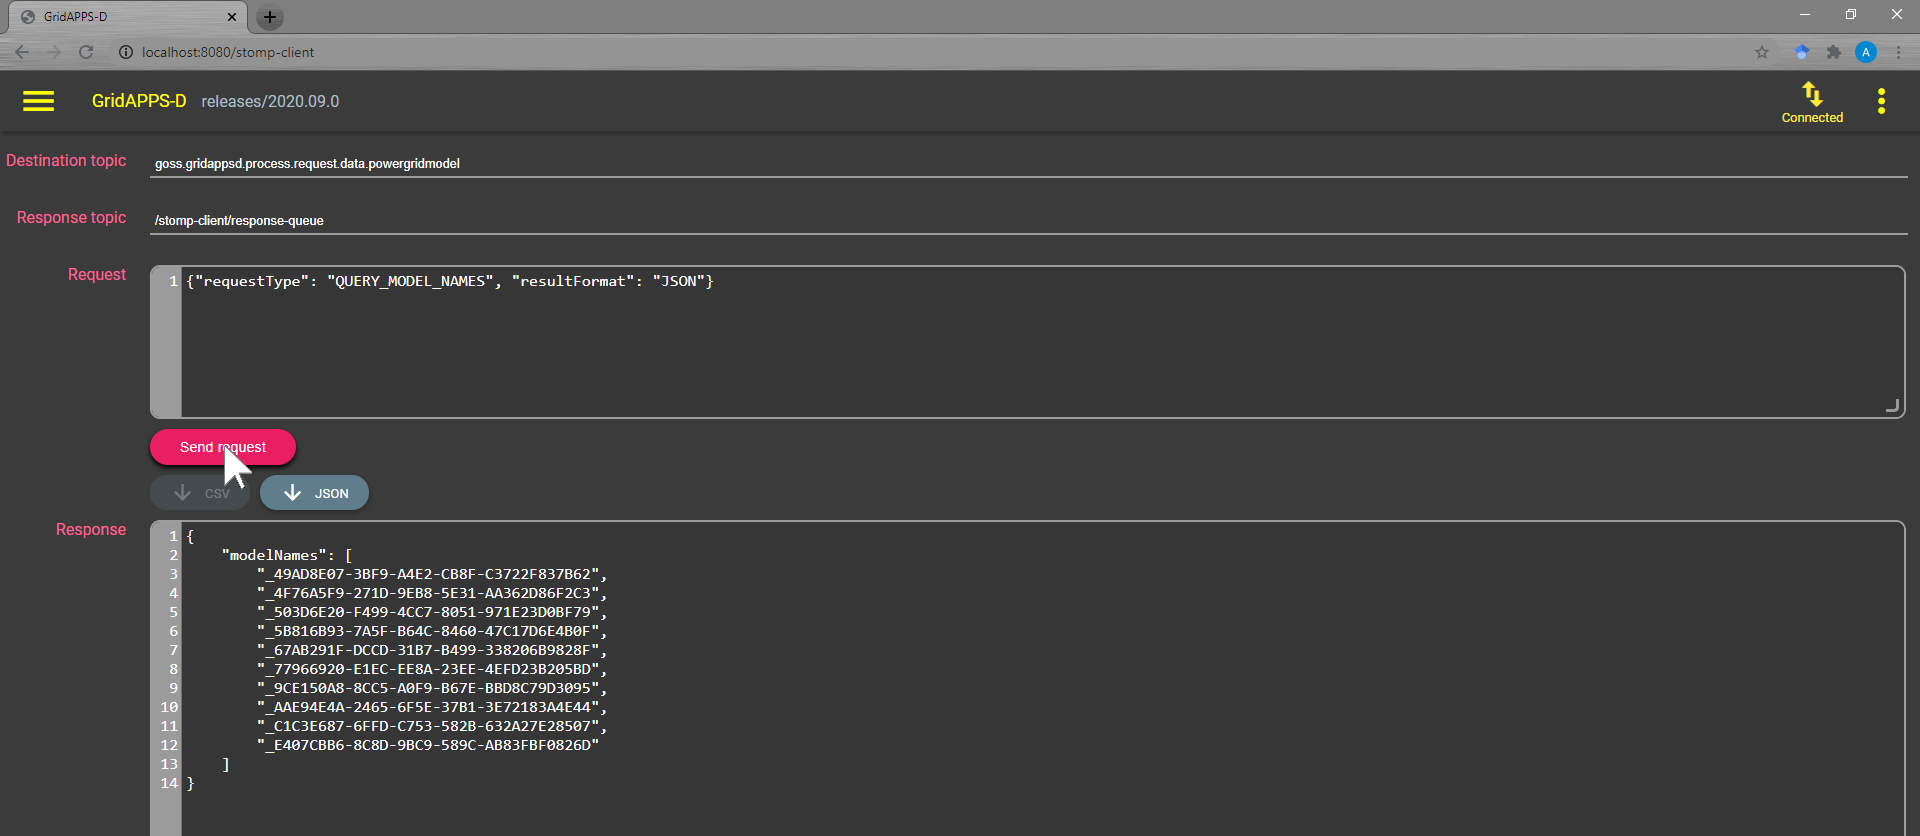

It can be seen that the response from the STOMP Client is identical to that obtained by passing the same topic and message using the GridAPPSD-Python Library:

In [ ]:
from gridappsd import GridAPPSD # Import Libraries
gapps = GridAPPSD("('localhost', 61613)", username='system', password='manager') # Connect to Platform
topic = "goss.gridappsd.process.request.data.powergridmodel" # Specify correct Topic
message = {
    "requestType": "QUERY_MODEL_NAMES",
    "resultFormat": "JSON"
} # Sample PowerGrid Model API message
gapps.get_response(topic, message) # Pass API call to Platform

---